In [1]:
from pandas import *
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from datetime import datetime
from time import time
import matplotlib.pyplot as plt

In [ ]:
print(f'Start @ {datetime.now()}')

In [ ]:
data=read_csv('./telecom_churn.csv')
results = {}
data.shape
# data.shape
# data.head()
# data.dtypes
# data.isna().sum()

In [32]:
data=data.drop(['Unnamed: 0'], axis=1)
# data.dtypes
# data.columns

Encode 'X' data for feature selection

In [34]:
label_encoder=LabelEncoder()
for col in data.columns:
    # print(col)
    data[col]=label_encoder.fit_transform(data[col])
# X.head()
# X.dtypes
# data.dtypes

In [35]:
X=data.drop(['churn'], axis=1) # features
y=data['churn'] # target
# y[0]

In [37]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)

Feature Selection

In [ ]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

In [ ]:
# rf.feature_importances_

In [ ]:
rfe=RFECV(estimator=rf, cv=5, scoring='accuracy')
rfe.fit(X_train, y_train)

In [ ]:
rfe.get_support()

In [45]:
list(zip(X_train.columns, rfe.get_support()))

[('account_length', np.True_),
 ('area_code', np.False_),
 ('international_plan', np.True_),
 ('voice_mail_plan', np.False_),
 ('number_vmail_messages', np.True_),
 ('total_day_minutes', np.True_),
 ('total_day_calls', np.True_),
 ('total_day_charge', np.True_),
 ('total_eve_minutes', np.True_),
 ('total_eve_calls', np.True_),
 ('total_eve_charge', np.True_),
 ('total_night_minutes', np.True_),
 ('total_night_calls', np.True_),
 ('total_night_charge', np.True_),
 ('total_intl_minutes', np.True_),
 ('total_intl_calls', np.True_),
 ('total_intl_charge', np.True_),
 ('customer_service_calls', np.True_)]

In [ ]:
feature_selected=[col_name for col_name, col_vec in list(zip(X_train.columns, rfe.get_support())) if(col_vec == True)]
feature_selected

In [ ]:
X_train[feature_selected]

Model Classification

In [50]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [54]:
clf_start=time()
print(f'CLF start @ {datetime.now()}')
# Train and evaluate the classifiers
for name, clf in classifiers.items():
    clf.fit(X_train[feature_selected], y_train)  # Train the model
    y_pred = clf.predict(X_test[feature_selected])  # Make predictions on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store the results
clf_end=time()
print(f'CLF end @ {datetime.now()}')

CLF start @ 2024-10-18 18:12:19.511953


c:\Users\Phreaker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CLF end @ 2024-10-18 18:12:26.016802


In [55]:
# Print the accuracy results
print("Classifier Performance:")
for clf_name, accuracy in results.items():
    print(f"{clf_name}: {accuracy:.4f}")
print(f"Time used: {clf_end-clf_start}s")

Classifier Performance:
Logistic Regression: 0.8681
SVM: 0.8771
Random Forest: 0.9580
Gradient Boosting: 0.9580
K-Nearest Neighbors: 0.8681
Time used: 6.5048487186431885s


In [59]:
results.keys()

dict_keys(['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors'])

In [62]:
# variables to plot graph
y_plt=[acc for acc in results.values()]
x_plt=[name for name in results.keys()]

x_plt

['Logistic Regression',
 'SVM',
 'Random Forest',
 'Gradient Boosting',
 'K-Nearest Neighbors']

Actual prediction

In [64]:
# Initialize the base classifiers
log_clf = LogisticRegression()
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
knn_clf = KNeighborsClassifier()

In [66]:
voting_clf = VotingClassifier(
    estimators=[
        ('log_clf', log_clf),
        ('svm_clf', svm_clf),
        ('rf_clf', rf_clf),
        ('gb_clf', gb_clf),
        ('knn_clf', knn_clf)
    ],
    voting='soft'
)

v_clf_start=time()
print(f'Voting start @ {datetime.now()}')
# Train VotingClassifier
voting_clf.fit(X_train[feature_selected], y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test[feature_selected])

print(f'Voting end @ {datetime.now()}')

Voting start @ 2024-10-18 18:19:55.802246


c:\Users\Phreaker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting end @ 2024-10-18 18:20:02.991832


In [ ]:
y_pred_voting

In [68]:
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
v_clf_end=time()
print(f"Voting time: {v_clf_end-v_clf_start}s")
print(f'End @ {datetime.now()}')

Voting Classifier Accuracy: 0.8996
Voting time: 106.76717972755432s
End @ 2024-10-18 18:21:42.569426


Graph for customer churn output

In [72]:
x_data=DataFrame({'churn':y_pred_voting})['churn'].value_counts().sort_index()
y_name=['No(0)','Yes(1)']
x_data

churn
0    640
1     27
Name: count, dtype: int64

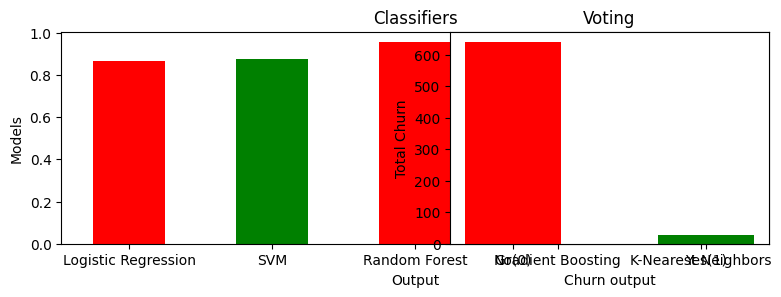

In [ ]:
plt.figure(figsize=(8,6))

plt.subplot(211)
plt.bar(x_plt,y_plt,color=['red','green'],width=0.5)
plt.xlabel('Output')
plt.ylabel('Models')
plt.title('Classifiers')

plt.subplot(212)
plt.bar(y_name,x_data,color=['red','green','blue'],width=0.5)
plt.xlabel('Churn output')
plt.ylabel('Total Churn')
plt.title('Voting')

plt.tight_layout()

plt.savefig('OutputImage/figure.png')
plt.show()